In [0]:
# remove this line to get outputs
%%capture
##########
!pip install pyworld
!pip install soundfile
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install plotly
!apt-get update
!apt-get install libsndfile-dev -y
!pip install pysptk


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
##https://colab.research.google.com/notebook#fileId=1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q&scrollTo=XoDG4oKpoeyS
# remove this line to get outputs
%%capture
##########
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [6]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [7]:
# Create a directory and mount Google Drive using that directory.
!fusermount -u drive
!rmdir drive
!mkdir -p drive

!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
rmdir: failed to remove 'drive': No such file or directory


In [8]:
import os
print('Files in Drive:')
basePath = 'drive/Colab_Notebooks/TigerCostume'
escapedBasePath = str.replace(basePath, ' ', '\ ')
print(os.listdir(basePath))

Files in Drive:
['RUN_MODELS.ipynb', 'local_modules.ipynb', 'testing', 'Dataset Analysis.ipynb', 'clean_tiger_costume.ipynb', 'local_modules', 'python', 'tiger_costume.ipynb', 'train_data', 'images', 'citations', 'sounds', 'train_samples', 'papers', 'IEEE_days.ipynb']


In [0]:
import sys
sys.path.append(basePath+'/local_modules')
# Now we can import our new module and call our function.
from regression import *
from display import *
from cepstrum_dtw import *

from dataset import *
import os
import pyworld as pw
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

import IPython
from IPython.core.display import HTML, clear_output

import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

from __future__ import absolute_import, division, print_function
from scipy.fftpack import dct
from scipy import signal
import scipy
import pysptk

In [0]:
def toquefrency(f0):
  #$sptk/sopr -magic 0.0 -LN -MAGIC -1.0E+10 > ${lf0_dir}/$file_id.lf0
  lf0 = np.zeros(f0.shape,dtype=float)
  magic = np.array(np.where(f0 <= 0))
  imask = np.ones(f0.shape,dtype=bool)
  imask[magic] = False
  lf0[np.logical_not(imask)] = -1.0e10;
  lf0[imask] = np.log(f0[imask])
  return lf0

def tofrequency(lf0):
  #{sopr} -magic -1.0E+10 -EXP -MAGIC 0.0 {lf0} | {x2x} +fd > {f0}'.format(sopr=SPTK['SOPR'], lf0=files['lf0'], x2x=SPTK['X2X'], f0=files['f0']
  f0 = np.zeros(lf0.shape,dtype=float)
  magic = np.array(np.where(lf0 <= -1e10))
  imask = np.ones(lf0.shape,dtype=bool)
  imask[magic] = False
  f0[np.logical_not(imask)] = 0.0
  f0[imask] = np.exp(lf0[imask])
  return f0

def frommgc(mgc):
  #run_process('{mgc2sp} -g 0 -l {fl} -o 2 {mgc} | {sopr} -d 32768.0 -P | {x2x} +fd > {sp}'
  #          .format(mgc2sp=SPTK['MGC2SP'], alpha=cfg.fw_alpha, order=cfg.mgc_dim-1, fl=cfg.fl, mgc=mgc_file_name, sopr=SPTK['SOPR'], x2x=SPTK['X2X'], sp=files['sp']))
  mgci = pysptk.sptk.mgc2sp(mgc, alpha=alpha, fftlen = nFFTHalf,gamma = 0)
  mgci = np.power(mgci/32768.0,2)
  return mgci
  
  
def tomgc(sp):
  #$sptk/sopr -R -m 32768.0
  mgc = np.sqrt(sp)*32768.0
  #$sptk/mcep -a $alpha -m $mcsize -l $nFFTHalf -e 1.0E-8 -j 0 -f 0.0 -q 3 
  mgc  = pysptk.sptk.mcep(sp,order = mcsize, alpha=alpha, maxiter=0, etype=1, eps=1e-8, min_det=0.0,
         itype=4)
   
  return mgc


def trim_zeros_frames(f0, sp, ap, eps=1e-7):
    """Remove trailling zeros frames.
    Similar to :func:`numpy.trim_zeros`, trimming trailing zeros features.
    Args:
        x (numpy.ndarray): Feature matrix, shape (``T x D``)
        eps (float): Values smaller than ``eps`` considered as zeros.
    Returns:
        numpy.ndarray: Trimmed 2d feature matrix, shape (``T' x D``)
    Examples:
        >>> import numpy as np
        >>> from nnmnkwii.preprocessing import trim_zeros_frames
        >>> x = np.random.rand(100,10)
        >>> y = trim_zeros_frames(x)
    """

    T, D = sp.shape
    s = np.sum(np.abs(sp), axis=1)
    #print(s)
    s[s < eps] = 0.0
    lz = len(s) - len(np.trim_zeros(s,'f'));
    tz = len(s) - len(np.trim_zeros(s,'b'));
    f0 = f0[lz:len(s)-tz]
    sp = sp[lz:(len(s)-tz),:]
    ap = ap[lz:(len(s)-tz),:]
    
    return lz, tz, f0, sp, ap
  
def feature_mv_norm(samples, cutoffs, means=None, stds=None):
    cut_f0 = cutoffs[0]
    cut_sp = cutoffs[1]
    
    f0 = samples[:, 0:cut_f0]
    sp = samples[:, cut_f0:cut_sp+1]
    
    uv = (f0 == 0).astype(int)
    
    if means is not None:
        f0_mean = means[:cut_f0]
        sp_mean = means[cut_f0:cut_sp+1]
    else:
        f0_mean = np.mean(f0[(uv==0)])
        sp_mean = np.mean(sp, axis=0)
    
    f0_mn = f0 - f0_mean
    f0_mn[uv == 1] = 0.0;
    
    sp_mn = sp - sp_mean
    
    if stds is not None:
        f0_std = stds[:cut_f0]
        sp_std = stds[cut_f0:cut_sp+1]
    else:
        f0_std = np.std(f0_mn[(uv==0)])
        sp_std = np.std(sp_mn, axis=0)
    
    if f0_std == 0:
      f0_std = 1
    f0_mvn = f0_mn / f0_std
    
    sp_std[sp_std==0] = 1
    sp_mvn = sp_mn / sp_std
    
       
    out = np.concatenate((f0_mvn, sp_mvn), axis=1)
    means = np.concatenate((np.reshape(f0_mean,1), np.transpose(sp_mean)))
    stds = np.concatenate((np.reshape(f0_std,1), np.transpose(sp_std)))
    return out, means, stds, uv

def feature_mv_unnorm(samples, cutoffs, means, stds, uv):
    cut_f0 = cutoffs[0]
    cut_sp = cutoffs[1]
    
    f0_mvn = samples[:, :cut_f0]
    sp_mvn = samples[:, cut_f0:cut_sp+1]
    
    
    f0_mn = f0_mvn * stds[:cut_f0]
    sp_mn = sp_mvn * stds[cut_f0:cut_sp+1]
    
    f0 = f0_mn + means[:cut_f0]
    sp = sp_mn + means[cut_f0:cut_sp+1]
    
    f0[uv==1] = 0
    
    out = np.concatenate((f0, sp), axis=1)
    return out

# DATA

## Dataset Configuration

In [11]:
# Configuration parameters 

N_S_TS = 20 # Number of source trainsamples
N_T_TS = 20 # Number of source trainsamples

fs = 16000

dec_factor = 1
fs_ds = int(fs/dec_factor);

N_t = 0.020
w_ratio = 4;
M_t = N_t/w_ratio;

f0_floor = 71.0
f0_ceil = 800.0
frame_period = M_t*1000;
w_ratio_samples = int(frame_period*(fs_ds/1000))


q1 = -0.15
threshold = 0.85

fft_size = pw.get_cheaptrick_fft_size(fs_ds,f0_floor)

nFFTHalf=1024 
alpha=0.58
mcsize=59
order=4

f_stop = 4000
sp_coefs = int(round(f_stop*fft_size/fs_ds*2))
feature_size = mcsize+2


print("N_t (Long ventana): %.3f s" % (N_t))
print("M_t (Avance ventana): %.3f s" % (M_t))

print("Numero de ventanas(f0) por ventana (N): %d " % (w_ratio))
print("Periodo de ventana para f0: %.3f s" % (frame_period/1000))
print("Tamaño FFT: %.3f s" % (fft_size))
print("SP coefs: %.3f" % (sp_coefs))
print("Feature size: %.3f" % (feature_size))

print("Factor de diezmado: %d" % (dec_factor))
print("Fs: %.2f Hz to %.2f Hz" % (fs, fs_ds))

N_t (Long ventana): 0.020 s
M_t (Avance ventana): 0.005 s
Numero de ventanas(f0) por ventana (N): 4 
Periodo de ventana para f0: 0.005 s
Tamaño FFT: 1024.000 s
SP coefs: 512.000
Feature size: 61.000
Factor de diezmado: 1
Fs: 16000.00 Hz to 16000.00 Hz


In [12]:
dataset_name = 'unos'
print('loading Source')
X = np.load(basePath+"/train_data/"+dataset_name+"/features/S_FULL.npy")
print('loading Target')
T = np.load(basePath+"/train_data/"+dataset_name+"/features/T_FULL.npy")
print(X.shape)
print(T.shape)
st_len = np.load(basePath+"/train_data/"+dataset_name+"/features/batchwise_length.npy")
print(st_len.shape)

Xn, Xmeans, Xstds, Xuv = feature_mv_norm(X, [1, mcsize+1])
Tn, Tmeans, Tstds, Tuv = feature_mv_norm(T, [1, mcsize+1])

loading Source
loading Target
(14101, 61)
(14101, 61)
(400,)


# Define

## Regression. Dense linear model. Fitted with ML. 
##p(w|alpha, Beta, D): p(D|w, Beta)*p(W|alpha)

---



*   Adjustable Weight decay -> 0 Mean Normal prior on weights: W ~N(0, Alpha^-1) to avoid fitting noise. Also ensures matrix invertibility.
*   Adjustable Beta uncertainty factor to model noise. t ~N(y=w*x, Beta^-1)
*   Noise sensibility ~Beta/Alpha

Residuals converge to noise variance with enough training points


In [0]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1337)


class dense_linear_LS(nn.Module):
    def __init__(self, cuda):
        super(dense_linear_LS, self).__init__()
        self.W = None  # Weights
        self.cuda = cuda

    def forward(self, x):
        # x = inputs (Nsamples, dim)
        # y = outputs (Nsamples, dim)
        if self.cuda:
            bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor).cuda()
        else:
            bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor)
        x = torch.cat((bx, x), 1).t()
        y = self.W.t().matmul(x)
        return torch.t(y)

    def fit(self, x, t, alpha=0.0000001, beta=1, bias=True):
        # x = inputs (Nsamples, dim)
        # t = targets (Nsamples, dim)
        # residuals = output (Nsamples, dim)
        if self.cuda:
            bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor).cuda()
        else:
            bx = torch.ones(x.shape[0], 1).type(torch.DoubleTensor)
        a = torch.cat((bx, x), dim=1)
        if self.cuda:
            wd = alpha * torch.eye(a.shape[1]).type(torch.DoubleTensor).cuda()
        else:
            wd = alpha * torch.eye(a.shape[1]).type(torch.DoubleTensor)
        inner = torch.matmul(a.t(), a)
        pseusoInvX = torch.inverse(wd + beta * inner).matmul(beta * a.t())
        self.W = pseusoInvX.matmul(t)
        if bias == False:
            self.W[0, :] = 0
        residuals = t - self.forward(x)
        return residuals


## Regression. NN,


In [0]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        self.epoch = 0

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

class Nloss_GD(nn.Module):
    def __init__(self, dim):
        super(Nloss_GD, self).__init__()
        self.dim = dim
        
        torch.manual_seed(0)
        
    def get_likelihoods(self, X, Y, Beta, eps=1e-6):
        # Returns likelihoods of each datapoint for every cluster         
        # batch_size
        inv_det = Beta.prod(dim=1)
        
        if (inv_det < eps).any():
            inv_det += (inv_det < eps).type(torch.cuda.FloatTensor) * eps 
            
        det = 1/inv_det
        print(torch.sqrt((2*np.pi)**self.dim * torch.abs(det)))
        # batch_size
        norm_term = 1/torch.sqrt((2*np.pi)**self.dim * torch.abs(det))
        #batch_size, dims
        inv_covars = Beta
        # batch_size, dims
        dist = (Y - X).pow(2)
        # batch_size
        exponent = (-0.5 * dist * inv_covars).sum(dim=1)
        # batch_size
        pk = norm_term * exponent.exp()
        return pk
      
    def get_log_likelihoods(self, X, Y, sq_Beta, eps=1e-6):
        # Returns likelihoods of each datapoint for every cluster    
        Beta = sq_Beta**2
        # batch_size
        log_det_term = 0.5*(Beta.log().sum(dim=1))
        #print('detterm shape:', log_det_term.shape)
        # 1
        norm_term = -0.5*np.log(2*np.pi)*self.dim
        #print('normterm shape:', norm_term.shape)
        #batch_size, dims
        inv_covars = Beta
        # batch_size, dims
        dist = (Y - X).pow(2)
        # batch_size
        exponent = (-0.5 * dist * inv_covars).sum(dim=1)
        #print('exponent shape:', exponent.shape)
        # batch_size
        log_p = (log_det_term + exponent) + norm_term
        #print('log_p shape:', log_p.shape)
        return log_p
        
        
    def forward(self, x, y, Beta):
        # Returns -loglike of all data        
        # batch_size
        #print(Beta.mean())
        p = self.get_log_likelihoods(x, y, Beta)
        # 1
        E = torch.sum( -p ) / x.shape[0]
        return E
      
      
class feed_forward(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(feed_forward, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, n_hid)
        self.fc4 = nn.Linear(n_hid, output_dim)
        self.log_sig = nn.LogSigmoid()
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc3(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc4(x)
        return y
      
class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid, n_bottleneck):
        super(Autoencoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_bottleneck)
        self.fc3 = nn.Linear(n_bottleneck, n_hid)
        self.fc4 = nn.Linear(n_hid, output_dim)

        # choose your non linearity
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):
        print(type(x.data))
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc3(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc4(x)
        # -----------------
        
        return y
    
    def get_features(self, x):
        
        return None
      
class inputs_3embedding_hid(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(inputs_3embedding_hid, self).__init__()
               
        self.fc1_0 = nn.Linear(input_dim, n_hid)
        self.fc1_1 = nn.Linear(input_dim, n_hid)
        self.fc1_2 = nn.Linear(input_dim, n_hid)
        
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
      # x (batch_size, 3, input_dim)
        x0 = x[:,0,:]
        x1 = x[:,1,:]
        x2 = x[:,2,:]
        # -----------------
        a0 = self.fc1_1(x0)
        a1 = self.fc1_2(x1)
        a2 = self.fc1_3(x2)
        # -----------------
        a = self.act(a0 + a1 + a2)
        # -----------------
        a = self.fc2(a)
        # -----------------
        a = self.act(a)
        # -----------------
        a = self.fc3(a)
        return a
      
class ff_mlpg(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(ff_mlpg, self).__init__()
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, int(1.5*n_hid))
        self.fc3 = nn.Linear(int(1.5*n_hid), 2*n_hid)
        self.fc4 = nn.Linear(2*n_hid, output_dim)
        self.drop = nn.Dropout(p=0.2, inplace=False)

        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.drop(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.drop(x)
        # -----------------
        x = self.fc3(x)
        # -----------------
        x = self.drop(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc4(x)
        
        out = y[:, :int(self.output_dim/2)]
        sq_Beta = y[:, int(self.output_dim/2):]
        
        return out, sq_Beta
      

class Net(BaseNet):
    def __init__(self, name, input_dim, output_dim, n_hid, n_bottleneck=None, lr=1e-4, weight_decay=0, cuda=True):
        super(Net, self).__init__()
        cprint('c', '\nNet:')
        self.name = name
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_bottleneck = n_bottleneck
        self.n_hid = n_hid
        self.cuda = cuda
        self.create_net()
        self.create_opt(lr, weight_decay)

    def create_net(self):
      
      if self.name == 'feed_forward':
          self.model = feed_forward(self.input_dim, self.output_dim, self.n_hid)
          self.J = nn.MSELoss(size_average=True, reduce=True)
      elif self.name == 'autoencoder':
          self.model = Autoencoder(self.input_dim, self.output_dim, self.n_hid, self.n_bottleneck)
          self.J = nn.MSELoss(size_average=True, reduce=True)
      elif self.name == 'ff_mlpg':
          self.model = ff_mlpg(self.input_dim, self.output_dim, self.n_hid)
          self.J = Nloss_GD(self.input_dim)
      else:
          pass
      
      
      if self.cuda:
          self.model = self.model.cuda()
          self.J = self.J.cuda()
      print('    Total params: %.2fM' % (sum(p.numel() for p in self.model.parameters()) / 1000000.0))

    def create_opt(self, lr=1e-4, weight_decay=0):
        self.lr = lr
        self.weight_decay=weight_decay
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.schedule = [100,200]  # [-1] #[50,200,400,600]

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), volatile=False, cuda=self.cuda)

        self.optimizer.zero_grad()
        if self.name == 'ff_mlpg':
            out, Beta = self.model(x)
            loss = self.J(out, y, Beta)
            loss.backward()
            self.optimizer.step()
            return loss.data[0], Beta.abs().mean().data
        elif self.name == 'feed_forward':
            out = self.model(x)
            loss = self.J(out, y)
        else:
            out = self.model(x)
            loss = self.J(out, y)
        loss.backward()
        self.optimizer.step()

        return loss.data[0]

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y), volatile=True, cuda=self.cuda)

        if self.name == 'ff_mlpg':
            out, Beta = self.model(x)
            loss = self.J(out, y, Beta)
            return loss.data[0], Beta.abs().mean().data
        elif self.name == 'feed_forward':
            out = self.model(x)

            loss = self.J(out, y)
        else:
            out = self.model(x)
            loss = self.J(out, y)
        return loss.data[0]

    def predict(self, x, train=False):
        x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)

        if self.name == 'ff_mlpg':
            out, Beta = self.model(x)
            return out.data, Beta.abs().data
        else:
            out = self.model(x)
            return out.data


## MLPG


In [0]:
def get_mtx_deltas(X, filter1, filter2):
    Nwin = X.shape[0]
    W1 = get_delta_mtx(filter1, Nwin)
    W2 = get_delta_mtx(filter2, Nwin)
    delta1 = np.dot(W1, X)
    delta2 = np.dot(W2, X)
    
    out = np.concatenate((X, delta1, delta2), axis=1)
    return out
    

def get_delta_mtx(the_filter, Nwin):
    # returns Nwin by Nwin matrix W1. W1 * base_features = delta1 
    Fsize = len(the_filter)
    T_pad = (Fsize-1)
    Nwin_pad = Nwin + T_pad
    pad_s = int(T_pad/2)
    pad_e = int(T_pad/2) #+ Nwin_pad%2
    #print('padding start, end:', pad_s, pad_e)
    # Generate Filter
    W1 = np.zeros((Nwin, Nwin_pad))
    for i in range(Nwin_pad - Fsize + 1):
        W1[i, i:i+Fsize] = the_filter
    W1 = W1[:,pad_s:]   
    W1 = W1[:,:-pad_e]
    return W1



def my_mlpg(features, dims, W1, W2, Beta):
  # Beta is precision of each dim: inverse of var. Pls sanitize before introducing.
    Nwins = features.shape[0]
    y = features[:, 0:dims]
    delta1_y = features[:, dims:2*dims]
    delta2_y = features[:, 2*dims:3*dims]
    W0 = np.eye(Nwins)
    ml_params = np.zeros((Nwins, dims))
    
    for d in range(dims):
        # Variance of each parameter along dimension d
        D0 = Beta[:, d] * np.eye(Nwins)
        D1 = Beta[:, dims+d] * np.eye(Nwins)
        D2 = Beta[:, 2*dims+d] * np.eye(Nwins)
        # Mean output of each parameter from neural net
        U0 = y[:, d]
        U1 = delta1_y[:, d]
        U2 = delta2_y[:, d]
        # Compute first term
        wdw0 = D0
        wdw1 = np.transpose(W1).dot(D1).dot(W1)
        wdw2 = np.transpose(W2).dot(D2).dot(W2)
        WDW = wdw0 + wdw1 + wdw2
        # computer second term
        wdu0 = D0.dot(U0)
        wdu1 = np.transpose(W1).dot(D1).dot(U1)
        wdu2 = np.transpose(W2).dot(D2).dot(U2)
        WDU = wdu0 + wdu1 + wdu2
        
        vec_params = np.dot(np.linalg.inv(WDW), WDU)
        ml_params[:, d] = vec_params
        
    return ml_params

# Train


## Dense Linear

In [0]:
from __future__ import division, print_function
import torch
import time
#######
savedir = basePath+'/train_data/'

use_cuda = torch.cuda.is_available()

weight_decay = 1e-2
beta = 0.0001
model = dense_linear_LS(cuda=use_cuda)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c','\nTrain:')

cutoff = np.round(X.shape[0] * 0.9).astype(int)

Xn, Xmeans, Xstds, Xuv = feature_mv_norm(X, [1, mcsize+1])
Tn, Tmeans, Tstds , Tuv= feature_mv_norm(T, [1, mcsize+1])

shuffle_in_unison_scary(Xn, Tn)

x_train = torch.from_numpy(Xn[0:cutoff, :])
t_train = torch.from_numpy(Tn[0:cutoff, :])

x_dev = torch.from_numpy(Xn[cutoff:, :])
t_dev = torch.from_numpy(Tn[cutoff:, :])

print('train set shape: %s' % str(x_train.shape))
print('test set shape: %s' % str(x_dev.shape))

if use_cuda:
    x_train = x_train.cuda()
    t_train = t_train.cuda()
    x_dev = x_dev.cuda()
    t_dev = t_dev.cuda()



tic0 = time.time()

res = model.fit(x_train, t_train, alpha=weight_decay, beta=beta, bias=True)
residual_var = res.pow(2).mean()
toc0 = time.time()

print('residual train variance = %f' % residual_var)
print('W shape: %s' % str(model.W.shape))

runtime =  (toc0 - tic0)
cprint('r','   runtime: %f seconds\n' % runtime)

cprint('c','\nTest:')

print('target shape %s'% str(t_dev.shape))
print('input shape %s'% str(x_dev.shape))
out = model(x_dev)
print('output shape %s'% str(out.shape))

J_test = (t_dev - out).pow(2).mean()
print('residual test variance = %f' % J_test)

## ---------------------------------------------------------------------------------------------------------------------
# save model
torch.save(model, savedir+'denseLS.dat')

## ---------------------------------------------------------------------------------------------------------------------

## ---------------------------------------------------------------------------------------------------------------------


Train:
train set shape: torch.Size([24510, 61])
test set shape: torch.Size([2723, 61])
residual train variance = 0.737251
W shape: torch.Size([62, 61])
   runtime: 0.312416 seconds


Test:
target shape torch.Size([2723, 61])
input shape torch.Size([2723, 61])
output shape torch.Size([2723, 61])
residual test variance = 0.745409


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:158: UserWarning:

Couldn't retrieve source code for container of type dense_linear_LS. It won't be checked for correctness upon loading.



0.0


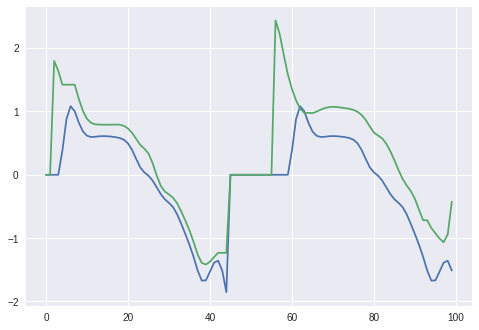

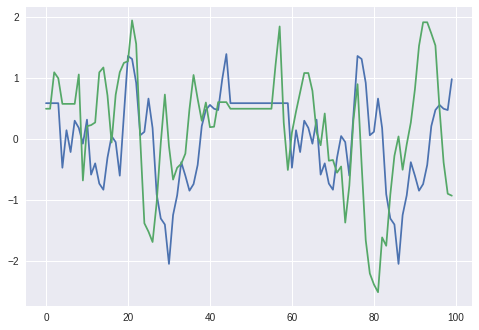

In [0]:
Xn,Xmeans,Xstds,Xuv = feature_mv_norm(X, [1, mcsize+1])
Tn, Tmeans, Tstds,Tuv = feature_mv_norm(T, [1, mcsize+1])

plt.figure()
offset = 0
lim = 100
plt.plot(Xn[offset:offset+lim,0])
plt.plot(Tn[offset:offset+lim,0])
plt.figure()
Nc = 45
plt.plot(Xn[offset:offset+lim,Nc])
plt.plot(Tn[offset:offset+lim,Nc])
print(sum(X[offset+50, 1:]))

## NN


Net:
    Total params: 0.15M
train set shape: (13396, 61)
targets shape: (13396, 61)
test set shape: (705, 61)
batch_size: 64
it 0/30, Jtr = 0.793175    time: 0.968971 seconds

    Jdev = 0.643660

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 1/30, Jtr = 0.590088    time: 0.979000 seconds

    Jdev = 0.575971

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 2/30, Jtr = 0.539259    time: 0.974738 seconds

    Jdev = 0.545719

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 3/30, Jtr = 0.514051    time: 0.957366 seconds

    Jdev = 0.526861

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 4/30, Jtr = 0.497814    time: 0.933135 seconds

    Jdev = 0.516303

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 5/30, Jtr = 0.486279    time: 0.925834 seconds

    Jdev = 0.503762

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 6/30, Jtr = 

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 19/30, Jtr = 0.411173    time: 1.006010 seconds

    Jdev = 0.443039

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 20/30, Jtr = 0.408511    time: 1.015542 seconds

    Jdev = 0.441479

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 21/30, Jtr = 0.406378    time: 0.957701 seconds

    Jdev = 0.439206

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 22/30, Jtr = 0.404345    time: 0.963761 seconds

    Jdev = 0.436964

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 23/30, Jtr = 0.402540    time: 0.947757 seconds

    Jdev = 0.436815

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 24/30, Jtr = 0.400478    time: 0.938087 seconds

    Jdev = 0.434843

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

it 25/30, Jtr = 0.399034    time: 0.932686 seconds

    Jdev = 0.

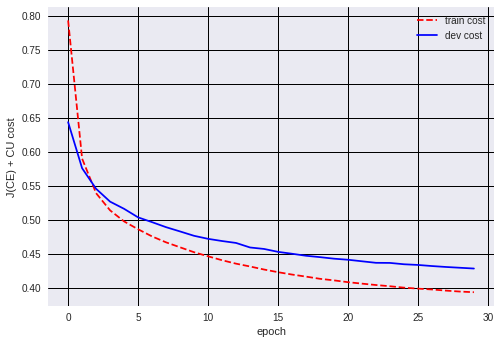

In [0]:
from __future__ import division, print_function
import time
#######
savedir = basePath+'/train_data/'

Xn,Xmeans,Xstds, Xuv = feature_mv_norm(X, [1, mcsize+1])
Tn, Tmeans, Tstds, Tuv = feature_mv_norm(T, [1, mcsize+1])

## Concatenate UV bit
# Xn = np.concatenate((Xn, Xuv), axis = 1)
# Tn = np.concatenate((Tn, Tuv), axis = 1)

shuffle_in_unison_scary(Xn, Tn)

cutoff = np.round(X.shape[0] * 0.95).astype(int)

x_train = Xn[0:cutoff, :]
t_train = Tn[0:cutoff, :]

x_dev = Xn[cutoff:, :]
t_dev = Tn[cutoff:, :]

# --------------------
# instantiate net
input_dim = x_train.shape[1]
output_dim = t_train.shape[1]
n_hid = int(4*input_dim)
use_cuda = torch.cuda.is_available()


lr = 1e-4
weight_decay = 1e-6

net = Net('feed_forward', input_dim, output_dim, n_hid, lr=lr, weight_decay=weight_decay, cuda=use_cuda)
################

print('train set shape: %s' % str(x_train.shape))
print('targets shape: %s' % str(t_train.shape))
print('test set shape: %s' % str(x_dev.shape))

batch_size = 64
nb_epochs = 30
print('batch_size: %d' % batch_size)


cost_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)

nb_samples_train = len(x_train)
nb_samples_dev = len(x_dev)

best_cost = np.inf
nb_its_dev = 1
tic0 = time.time()
for i in range(nb_epochs):
    net.set_mode_train(True)
    # ---- W
    tic = time.time()
    #for x, y in trainloader:
    for ind in generate_ind_batch(nb_samples_train, batch_size, random=True):
        x, y = x_train[ind], t_train[ind]
        loss  = net.fit(x, y)
        cost_train[i] += loss / nb_samples_train * len(x)

    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr = %f " % (i, nb_epochs, cost_train[i]), end="")
    cprint('r','   time: %f seconds\n' % (toc - tic))
    net.update_lr(i)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        #print('eval mode on')
        #for x, y in testloader:
        for ind in generate_ind_batch(nb_samples_dev, batch_size, random=False):
            x, y = x_dev[ind], t_dev[ind]
            cost =  net.eval(x, y)
            cost_dev[i] += cost / nb_samples_dev * len(x)
        cprint('g','    Jdev = %f\n' % (cost_dev[i]))
        if cost_dev[i] < best_cost:
            best_cost = cost_dev[i]
            net.save(savedir+'theta_best.dat')

toc0 = time.time()
runtime_per_it =  (toc0 - tic0)/float(nb_epochs)
cprint('r','   average time: %f seconds\n' % runtime_per_it)

## ---------------------------------------------------------------------------------------------------------------------
# save model
net.save(savedir+'theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c','\nRESULTS:')
cost_dev_min = cost_dev[::nb_its_dev].min()
cost_train_min = cost_train.min()
nb_parameters = net.get_nb_parameters()
print('  cost_dev: %f (cost_train %f)' % (cost_dev_min, cost_train_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
import matplotlib.pyplot as plt
#############################
plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('J(CE) + CU cost')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
plt.legend(['train cost', 'dev cost'])
plt.savefig('./cost.png')

## Autoencoder

In [0]:
from __future__ import division, print_function
import time
#######
savedir = basePath+'/train_data/'

# --------------------
# instantiate net

input_dim = sp_coefs+1
output_dim = sp_coefs+1
n_hid = int(0.6*input_dim)
n_bottle = int(0.1*input_dim) 
use_cuda = torch.cuda.is_available()


lr = 1e-4
weight_decay = 1e-6

net = Net('autoencoder', input_dim, output_dim, n_hid, n_bottleneck=n_bottle, lr=lr, weight_decay=weight_decay, cuda=use_cuda)

Xn,Xmeans,Xstds = feature_mv_norm(X, [1, sp_coefs])
Tn, Tmeans, Tstds = feature_mv_norm(T, [1, sp_coefs])

Xn = Xn[:, 0:sp_coefs+1]
Tn = Tn[:, 0:sp_coefs+1]

shuffle_in_unison_scary(Xn, Tn)

cutoff = np.round(X.shape[0] * 0.95).astype(int)

x_train = Xn[0:cutoff, :]
t_train = Tn[0:cutoff, :]

x_dev = Xn[cutoff:, :]
t_dev = Tn[cutoff:, :]

del Xn
del Tn

print('train set shape: %s' % str(x_train.shape))
print('targets shape: %s' % str(t_train.shape))
print('test set shape: %s' % str(x_dev.shape))

batch_size = 64
nb_epochs = 25
print('batch_size: %d' % batch_size)


cost_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)

nb_samples_train = len(x_train)
nb_samples_dev = len(x_dev)

best_cost = np.inf
nb_its_dev = 1
tic0 = time.time()
for i in range(nb_epochs):
    net.set_mode_train(True)
    # ---- W
    tic = time.time()
    #for x, y in trainloader:
    for ind in generate_ind_batch(nb_samples_train, batch_size, random=True):
        x, y = x_train[ind], t_train[ind]
        loss  = net.fit(x, y)
        cost_train[i] += loss / nb_samples_train * len(x)

    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr = %f " % (i, nb_epochs, cost_train[i]), end="")
    cprint('r','   time: %f seconds\n' % (toc - tic))
    net.update_lr(i)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        #print('eval mode on')
        #for x, y in testloader:
        for ind in generate_ind_batch(nb_samples_dev, batch_size, random=False):
            x, y = x_dev[ind], t_dev[ind]
            cost =  net.eval(x, y)
            cost_dev[i] += cost / nb_samples_dev * len(x)
        cprint('g','    Jdev = %f\n' % (cost_dev[i]))
        if cost_dev[i] < best_cost:
            best_cost = cost_dev[i]
            net.save(savedir+'auto_best.dat')

toc0 = time.time()
runtime_per_it =  (toc0 - tic0)/float(nb_epochs)
cprint('r','   average time: %f seconds\n' % runtime_per_it)

## ---------------------------------------------------------------------------------------------------------------------
# save model
net.save(savedir+'auto_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c','\nRESULTS:')
cost_dev_min = cost_dev[::nb_its_dev].min()
cost_train_min = cost_train.min()
nb_parameters = net.get_nb_parameters()
print('  cost_dev: %f (cost_train %f)' % (cost_dev_min, cost_train_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
import matplotlib.pyplot as plt
#############################
plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('J(CE) + CU cost')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
plt.legend(['train cost', 'dev cost'])
plt.savefig('./cost.png')


Net:


## MLPG

In [68]:
filter1 = np.array([-1.0000,   -0.7500,   -0.5000,   -0.2500,         0,    0.2500,    0.5000,   0.7500,    1.0000])
filter2 = np.array([ 1.0000,    0.2500,   -0.2857,   -0.6071,   -0.7143,   -0.6071,   -0.2857,   0.2500,    1.0000])

aug_dim = 61 * 3
cum_wins = 0
Xdd = np.empty((0,aug_dim))
Tdd = np.empty((0,aug_dim))
for wins in st_len:
    Xdd_i = get_mtx_deltas(X[cum_wins:cum_wins+wins, :], filter1, filter2)
    Tdd_i = get_mtx_deltas(T[cum_wins:cum_wins+wins, :], filter1, filter2)
    cum_wins += wins
    Xdd = np.concatenate((Xdd, Xdd_i), axis=0)
    Tdd = np.concatenate((Tdd, Tdd_i), axis=0)

print(Xdd.shape)
print(Tdd.shape)
print(X.shape)

(14101, 183)
(14101, 183)
(14101, 61)


In [0]:
from __future__ import division, print_function
import time
#######
savedir = basePath+'/train_data/'
mcsize_mlpg = 181
Xn,Xmeans,Xstds, Xuv = feature_mv_norm(Xdd, [1, mcsize_mlpg+1])
Tn, Tmeans, Tstds, Tuv = feature_mv_norm(Tdd, [1, mcsize_mlpg+1])

shuffle_in_unison_scary(Xn, Tn)
cutoff = np.round(X.shape[0] * 0.95).astype(int)

x_train = Xn[0:cutoff, :]
t_train = Tn[0:cutoff, :]

x_dev = Xn[cutoff:, :]
t_dev = Tn[cutoff:, :]

# --------------------
# instantiate net
input_dim = x_train.shape[1]
output_dim = 2*t_train.shape[1]
n_hid = int(2*input_dim)
use_cuda = torch.cuda.is_available()


lr = 1e-4
weight_decay = 0

net = Net('ff_mlpg', input_dim, output_dim, n_hid, lr=lr, weight_decay=weight_decay, cuda=use_cuda)
################

print('train set shape: %s' % str(x_train.shape))
print('targets shape: %s' % str(t_train.shape))
print('test set shape: %s' % str(x_dev.shape))

batch_size = 64
nb_epochs = 200
print('batch_size: %d' % batch_size)


cost_train = np.zeros(nb_epochs)
cost_dev = np.zeros(nb_epochs)
mean_sq_betas_train = np.zeros(nb_epochs)
mean_sq_betas_dev = np.zeros(nb_epochs)

nb_samples_train = len(x_train)
nb_samples_dev = len(x_dev)

best_cost = np.inf
nb_its_dev = 1
tic0 = time.time()
for i in range(nb_epochs):
    net.set_mode_train(True)
    # ---- W
    tic = time.time()
    #for x, y in trainloader:
    for ind in generate_ind_batch(nb_samples_train, batch_size, random=True):
        x, y = x_train[ind], t_train[ind]
        loss, mean_sq_Beta  = net.fit(x, y)
        cost_train[i] += loss / nb_samples_train * len(x)
        mean_sq_betas_train[i] += mean_sq_Beta / nb_samples_train * len(x)

    toc = time.time()

    # ---- print
    print("it %d/%d, Jtr = %f " % (i, nb_epochs, cost_train[i]), end="")
    cprint('r','   time: %f seconds\n' % (toc - tic))
    net.update_lr(i, gamma=0.1)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        #print('eval mode on')
        #for x, y in testloader:
        for ind in generate_ind_batch(nb_samples_dev, batch_size, random=False):
            x, y = x_dev[ind], t_dev[ind]
            cost, mean_sq_Beta =  net.eval(x, y)
            mean_sq_betas_dev[i] += mean_sq_Beta / nb_samples_dev * len(x)
            cost_dev[i] += cost / nb_samples_dev * len(x)
        cprint('g','    Jdev = %f\n' % (cost_dev[i]))
        if cost_dev[i] < best_cost:
            best_cost = cost_dev[i]
            net.save(savedir+'theta_best_mlpg.dat')

toc0 = time.time()
runtime_per_it =  (toc0 - tic0)/float(nb_epochs)
cprint('r','   average time: %f seconds\n' % runtime_per_it)

## ---------------------------------------------------------------------------------------------------------------------
# save model
net.save(savedir+'theta_last_mlpg.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c','\nRESULTS:')
cost_dev_min = cost_dev[::nb_its_dev].min()
cost_train_min = cost_train.min()
nb_parameters = net.get_nb_parameters()
print('  cost_dev: %f (cost_train %f)' % (cost_dev_min, cost_train_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its
import matplotlib
import matplotlib.pyplot as plt
#############################
plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('J(CE) + CU cost')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
plt.legend(['train cost', 'dev cost'])
plt.savefig('./cost.png')

plt.figure()
plt.plot(mean_sq_betas_train)
plt.plot(mean_sq_betas_dev)
plt.legend(['mean betas train', 'mean betas dev'])
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')



Net:
    Total params: 0.94M
train set shape: (13396, 183)
targets shape: (13396, 183)
test set shape: (705, 183)
batch_size: 64
it 0/200, Jtr = 585.715201    time: 1.495753 seconds

    Jdev = 469.540167

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 1/200, Jtr = 382.798351    time: 1.564485 seconds

    Jdev = 329.235012

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 2/200, Jtr = 289.383327    time: 1.588977 seconds

    Jdev = 263.725322

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 3/200, Jtr = 250.699651    time: 1.595609 seconds

    Jdev = 237.678191

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 4/200, Jtr = 235.452479    time: 1.527313 seconds

    Jdev = 224.247694

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 5/200, Jtr = 226.146287    time: 1.570294 seconds

    Jdev = 214.329291

Writting drive/Colab_Noteboo

    Jdev = 161.097060

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 19/200, Jtr = 169.692815    time: 1.593512 seconds

    Jdev = 157.964286

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 20/200, Jtr = 166.917073    time: 1.558537 seconds

    Jdev = 156.179816

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 21/200, Jtr = 164.594092    time: 1.570974 seconds

    Jdev = 153.333893

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 22/200, Jtr = 161.898432    time: 1.592870 seconds

    Jdev = 151.001704

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 23/200, Jtr = 159.947756    time: 1.584925 seconds

    Jdev = 149.615238

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 24/200, Jtr = 157.838696    time: 1.559288 seconds

    Jdev = 147.907713

Writting drive/Colab_Notebooks/TigerCostume/train_dat

    Jdev = 130.415442

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 38/200, Jtr = 135.374265    time: 1.591656 seconds

    Jdev = 128.400594

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 39/200, Jtr = 134.338283    time: 1.567157 seconds

    Jdev = 126.434543

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 40/200, Jtr = 133.090780    time: 1.577390 seconds

    Jdev = 127.235701

it 41/200, Jtr = 131.826811    time: 1.468402 seconds

    Jdev = 125.051823

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 42/200, Jtr = 131.244061    time: 1.581111 seconds

    Jdev = 125.960623

it 43/200, Jtr = 129.585231    time: 1.480222 seconds

    Jdev = 124.369417

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 44/200, Jtr = 128.660970    time: 1.549643 seconds

    Jdev = 122.790574

Writting drive/Colab_Notebooks/TigerCostume/train_d

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 61/200, Jtr = 114.019123    time: 1.574451 seconds

    Jdev = 110.215599

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 62/200, Jtr = 113.148961    time: 1.589174 seconds

    Jdev = 110.677281

it 63/200, Jtr = 112.404270    time: 1.501843 seconds

    Jdev = 111.450976

it 64/200, Jtr = 111.856655    time: 1.483925 seconds

    Jdev = 108.682495

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

it 65/200, Jtr = 111.368107    time: 1.535525 seconds

    Jdev = 109.855962

it 66/200, Jtr = 110.475732    time: 1.505990 seconds

    Jdev = 107.471401

Writting drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat



# RUN

N_t (Long ventana): 0.020 s
M_t (Avance ventana): 0.005 s
Numero de ventanas(f0) por ventana (N): 4 
Periodo de ventana para f0: 0.005 s
Tamaño FFT: 1024.000 s
SP coefs: 512.000
Factor de diezmado: 1
Fs: 16000.00 Hz to 16000.00 Hz


## Samples

In [0]:
# Now we can import our new module and call our function.
import cepstrum_dtw as cepdtw
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

def from_wav(file):
    x, fs  = sf.read(file)

    if x.ndim is 2:
        x = x[:, 0]
    x = x.copy(order='C').astype(float)
    return x,fs
  
def windower(x, M, N):
    # M avance entre vetanas
    # N windowsize

    T   = x.shape[0]
    m   = np.arange(0, T-N+1, M) # comienzos de ventana
    L   = m.shape[0] # N ventanas
    ind = np.expand_dims(np.arange(0, N), axis=1) * np.ones((1,L)) + np.ones((N,1)) * m
    X   = x[ind.astype(int)]
    return X.transpose()
  
def silence_filter(x, frame_period, fs, th=0.1):
    frame_samples = np.round(fs * frame_period / 1000).astype(int);

    N = (6 * frame_samples).astype(int);
    M = (2 * frame_samples).astype(int);
    
    x_w = windower(x, M, N);

    x_power = np.apply_along_axis(np.power, 0, np.absolute(x_w), 2)
    x_power = np.apply_along_axis(np.sum, 1, x_power)

    speech_th = np.array(np.where(x_power > th))
    speech_index = (speech_th * M).astype(int)
    noise_th = np.array(np.where(x_power <= th))
    noise_index = (noise_th * M).astype(int)
    # speech_length = np.transpose(np.concatenate((x_th*M, np.ones(x_th.shape)*M), axis=0))
    # speech_index = tuple(map(int,speech_index))
    x_fil = np.concatenate([x[offset:(offset + M)] for offset in speech_index[0]])
    return x_fil, speech_index, noise_index, M

def f0_start_end(f0):
  nzc = np.count_nonzero(f0)
  if nzc > 0:
    nz = np.flatnonzero(f0)    
    start = nz[0]
    end = nz[-1]
    if start == end:
      if np.count_nonzero(f0[0:start]):
        return (0,end)
      else:
        return (start, len(f0))
    else:
      if nz.size > 2:
        return (start, end)
  else:
    return ()

  
def train_samples(x, fs,ns=1, t1=400, t2=10, nth1=50, nth2=20, display=False):
    """Returns chunks of train samples from signal

    Args:
        x: Complete signal
        fs: Sample frequency
        t1: Duration of window (ms)
        t2: Slide length (ms)
        nth1: Upper threshold
        nth2: Bottom threshold


    Returns:
        Returns train samples of equal length

    """

    t = np.divide(np.arange(0, x.shape[0]), fs)

    L1 = x.shape[0]  # Signal length
    # T1 = 600*1e-3 # Window length
    # T2 = 20*1e-3 # Step lenght
    T1 = t1 * 1e-3  # Window length
    T2 = t2 * 1e-3  # Step lenght
    N1 = np.floor(T1 * fs).astype(int)  # Samples per window
    D1 = np.floor(T2 * fs).astype(int)  # Samples per step
    indice = np.arange(1, L1, D1, dtype=np.int32)  # Start indexes for windowing

    noise_power = np.sum(np.power(np.absolute(x[0:np.floor(ns*fs).astype(int) - 1]), 2))
    noise_th1 = nth1 * noise_power
    noise_th2 = nth2 * noise_power
    sflag = 0
    clip = np.zeros(x.shape)
    wp = np.zeros(x.shape)
    chunks = [];

    for i in np.arange(1, indice.shape[0] - 2):
        fin = np.min([indice[i] + N1, x.shape[0]]).astype(int)
        window_power = np.sum(np.power(np.absolute(x[indice[i]:fin]), 2))
        if (window_power > noise_th1 and sflag == 0):
            sflag = 1
            clip[indice[i]] = window_power
            chunks.append(indice[i]);
        elif (window_power < noise_th2 and sflag == 1):
            clip[indice[i] + N1] = window_power
            sflag = 0
            chunks.append(indice[i] + N1)
        wp[indice[i]] = window_power;

    if display:
      fig, ax1 = plt.subplots()
      ax1.plot(t, x, 'b-')
      ax1.set_xlabel('time (s)')
      # Make the y-axis label, ticks and tick labels match the line color.
      ax1.set_ylabel('signal', color='b')
      ax1.tick_params('y', colors='b')

      ax2 = ax1.twinx()
      ax2.plot(t, clip, 'r.')
      ax2.set_ylabel('wp', color='r')
      ax2.tick_params('y', colors='r')

      fig.tight_layout()
      plt.show()

    max_chunk_dur = np.max(np.subtract(chunks[1:2:], chunks[0:2:]))

    train_samples = np.zeros(((int)(len(chunks) / 2), max_chunk_dur))

    ti = 0;
    for i in np.arange(0, len(chunks), 2):
        chunk_dur = chunks[i + 1] - chunks[i];
        chunk_diff = max_chunk_dur - chunk_dur;
        if (np.mod(chunk_diff, 2) == 0):
            off_s = (int)(chunk_diff / 2);
            off_e = off_s;
        else:
            off_s = np.floor(chunk_diff / 2).astype(int);
            off_e = off_s + 1;
        train_samples[[ti], :] = x[chunks[i] - off_s:chunks[i + 1] + off_e];
        # soundsc(s(chunks(i):chunks(i+1)),fs)
        # pause
        ti = ti + 1

    return train_samples
  
def wvec_mv_norm(samples, cutoffs, means=None, stds=None):
    cut_f0 = cutoffs[0]
    cut_sp = cutoffs[1]
    
    f0 = samples[:, :cut_f0]
    sp = samples[:, cut_f0:cut_sp+1]
    ap = samples[:, cut_sp+1:]
    
    if means is not None:
        f0_mean = means[:cut_f0]
        sp_mean = means[cut_f0:cut_sp+1]
        ap_mean = means[cut_sp+1:]
    else:
        f0_mean = np.mean(f0)
        sp_mean = np.mean(sp, axis=0)
        ap_mean = np.mean(ap)
      
    f0_mn = f0 - f0_mean
    sp_mn = sp - sp_mean
    ap_mn = ap - ap_mean
    
    if stds is not None:
        f0_std = stds[:cut_f0]
        sp_std = stds[cut_f0:cut_sp+1]
        ap_std = stds[cut_sp+1:]
    else:
        f0_std = np.std(f0_mn)
        sp_std = np.std(sp_mn, axis=0)
        ap_std = np.std(ap_mn)
    
    if f0_std == 0:
      f0_std = 1
    f0_mvn = f0_mn / f0_std
    
    sp_std[sp_std==0] = 1
    sp_mvn = sp_mn / sp_std
    
    if ap_std == 0:
      ap_std = 1
    ap_mvn = ap_mn / ap_std
    
    out = np.concatenate((f0_mvn, sp_mvn, ap_mvn), axis=1)
    means = np.concatenate((np.reshape(f0_mean,1), np.transpose(sp_mean), np.reshape(ap_mean,1)))
    stds = np.concatenate((np.reshape(f0_std,1), np.transpose(sp_std), np.reshape(ap_std,1)))
    return out, means, stds

def wvec_mv_unnorm(samples, cutoffs, means, stds):
    cut_f0 = cutoffs[0]
    cut_sp = cutoffs[1]
    
    f0_mvn = samples[:, :cut_f0]
    sp_mvn = samples[:, cut_f0:cut_sp+1]
    ap_mvn = samples[:, cut_sp+1:]
    
    
    f0_mn = f0_mvn * stds[:cut_f0]
    sp_mn = sp_mvn * stds[cut_f0:cut_sp+1]
    ap_mn = ap_mvn * stds[cut_sp+1:]
    
    f0 = f0_mn + means[:cut_f0]
    sp = sp_mn + means[cut_f0:cut_sp+1]
    ap = ap_mn + means[cut_sp+1:]
    
    out = np.concatenate((f0, sp, ap), axis=1)
    return out

In [20]:
#@title Training samples
dataset_name = "unos" #@param ["unos", "otorrinolaringologo"]
from scipy import signal, misc

working_directory = basePath+'/train_data/' + dataset_name

print(os.listdir(working_directory))

if dataset_name == 'unos':
  file_javi = working_directory + '/wav/javi_uno.wav'
  file_alberto = working_directory + '/wav/alberto_uno.wav'
  file_raquel = working_directory + '/wav/raquel_uno.wav'

  x_javi,fs_wav = from_wav(file_javi)
  if not fs ==fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_javi = signal.decimate(x_javi, dec_factor, ftype='fir');
  ts_javi = train_samples(x_javi,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=50)

  x_alb,fs_wav = from_wav(file_alberto)
  if not fs == fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_alb = signal.decimate(x_alb, dec_factor, ftype='fir');
  ts_alb = train_samples(x_alb,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=60)

#   x_raq,fs_wav = from_wav(file_raquel)
#   if not fs == fs_wav:
#     print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
#   if dec_factor > 1:
#     x_raq = signal.decimate(x_raq, dec_factor, ftype='fir');
#   ts_raq = train_samples(x_raq,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)

elif dataset_name == 'otorrinolaringologo':
  
  file_javi = basePath + '/train_samples/javi_oto_16.wav'
  file_alberto = basePath + '/train_samples/alb_oto_16.wav'

  x_javi,fs_wav = from_wav(file_javi)
  if not fs ==fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_javi = signal.decimate(x_javi, dec_factor, ftype='fir');
  ts_javi = dataset.train_samples(x_javi,fs_ds,ns = 0.5,t1=250, t2=10, nth1=50, nth2=20)

  x_alb,fs_wav = from_wav(file_alberto)
  if not fs == fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_alb = signal.decimate(x_alb, dec_factor, ftype='fir');
  ts_alb = dataset.train_samples(x_alb,fs_ds,ns = 0.5,t1=250, t2=10, nth1=50, nth2=20)

#   x_raq,fs_wav = from_wav(file_raquel)
#   if not fs == fs_wav:
#     print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
#   if dec_factor > 1:
#     x_raq = signal.decimate(x_raq, dec_factor, ftype='fir');
#   ts_raq = train_samples(x_raq,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)
  
ts_s = ts_javi
print(ts_s.shape)
ts_t = ts_alb
print(ts_t.shape)

del x_javi
del x_alb
del ts_javi
del ts_alb

['features', 'wav']
(20, 14400)
(35, 6560)


In [21]:
from scipy import signal, misc

configure_plotly_browser_state()
init_notebook_mode(connected=False)

x = ts_s[5,:]
t = ts_t[16,:]

#Low Eneregy Silence filtering
t = silence_filter(t, frame_period, fs_ds)[0]

# F0 extraction of filtered signal 
f0_t, tp_t = pw.harvest(t, fs_ds,f0_floor, f0_ceil, frame_period)


sp_t = pw.cheaptrick(t, f0_t, tp_t, fs_ds, q1, f0_floor, fft_size)
ap_t = pw.d4c(t, f0_t, tp_t, fs_ds, threshold, fft_size)


layout = dict(title = 'SOURCE',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace = go.Scatter(
    x = np.array(range(len(x)))/fs_ds,
    y = x,
    mode = 'lines',
    name = 'x_rec'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)

sf.write(basePath + "/sounds/source_sample_wofil"+dataset_name+".wav", x, fs_ds)
wav_player(basePath + "/sounds/source_sample_wofil"+dataset_name+".wav")

#Low Eneregy Silence filtering
x = silence_filter(x, frame_period, fs_ds,th=1.4)[0]


# F0 extraction of filtered signal 
f0_s, tp_s = pw.harvest(x, fs_ds,f0_floor, f0_ceil, frame_period)


sp_s = pw.cheaptrick(x, f0_s, tp_s, fs_ds, q1, f0_floor, fft_size)
ap_s = pw.d4c(x, f0_s, tp_s, fs_ds, threshold, fft_size)

lz, tz, f0_s, sp_s, ap_s = trim_zeros_frames(f0_s,sp_s,ap_s, 0.7)

tx = x[int(lz*frame_period/1000*fs):int((len(x)-(tz*frame_period/1000*fs)))]

lf0_s = toquefrency(f0_s)
mgc_s = pysptk.conversion.sp2mc(sp_s, order = mcsize, alpha=alpha)


feature_s = np.concatenate((lf0_s.reshape(len(lf0_s),1), mgc_s),1)

feature_s[feature_s[:,0] == -1e10] = 0
sf.write(basePath + "/sounds/source_sample_"+dataset_name+".wav", x, fs_ds)
wav_player(basePath + "/sounds/source_sample_"+dataset_name+".wav")


layout = dict(title = 'SOURCE',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace = go.Scatter(
    x = np.array(range(len(x)))/fs_ds,
    y = x,
    mode = 'lines',
    name = 'x'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)

layout = dict(title = 'TRIMED SOURCE',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace = go.Scatter(
    x = np.array(range(len(tx)))/fs_ds,
    y = tx,
    mode = 'lines',
    name = 'tx'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)


## Dense Linear

In [0]:
from __future__ import print_function
from __future__ import division
import time, sys
import numpy as np

import torch.utils.data as data
import torchvision.transforms as transforms

np.random.seed(1337)  # for reproducibility

## ----------------------------------------------------------------------------------------------------------------
# read data
cprint('c','\nData:')

savedir = basePath+'/train_data/'


#######################
x = feature_s#########
#######################

ds_stats = np.load(basePath+"/train_data/"+dataset_name+"/features/ST_STATS.npy")
Xmeans = ds_stats[0]
Xstds = ds_stats[1]
Tmeans = ds_stats[3]
Tstds = ds_stats[4]


print('  x_test: %d vectors of audio' % (x.shape[0]))

x,_,_, in_uv = feature_mv_norm(x, [1, mcsize+1], Xmeans, Xstds)

x = torch.from_numpy(x)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
input_dim = x.shape[1]
use_cuda = torch.cuda.is_available()

if use_cuda:
  x = x.cuda()

print('  input_dim: %s' % str(input_dim))

# --------------------
model = torch.load(savedir + 'denseLS.dat')
## ---------------------------------------------------------------------------------------------------------------------
# test


cprint('c','\nTest:')
# ----
tic = time.time()

result = model(x)

if use_cuda:
    result = result.cpu().numpy()
else:
    result = result.numpy()
  

result = feature_mv_unnorm(result, [1, mcsize+1], Tmeans, Tstds, in_uv)
# plt.figure()
# plt.plot(result[:,0])
# plt.plot(in_uv)
toc = time.time()
print('  output_dim: %d' % result.shape[1])

# ----

cprint('r', '   time: %f seconds\n' % (toc - tic))


Data:
  x_test: 53 vectors of audio
  input_dim: 61

Test:
  output_dim: 61
   time: 0.001516 seconds



## NN

In [0]:
from __future__ import print_function
from __future__ import division
import time, sys
import numpy as np

import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

def np_sigmoid(x):
      out = 1/(1+np.exp(-x))
      return out

np.random.seed(1337)  # for reproducibility

## ----------------------------------------------------------------------------------------------------------------
# read data
cprint('c','\nData:')

savedir = basePath+'/train_data/'

#######################
x = feature_s#########
#######################

ds_stats = np.load(basePath+"/train_data/"+dataset_name+"/features/ST_STATS.npy")
Xmeans = ds_stats[0]
Xstds = ds_stats[1]
Tmeans = ds_stats[3]
Tstds = ds_stats[4]


weight_decay = 1e-6
print('  x_test: %d vectors of audio' % (x.shape[0]))

x,_,_,in_uv = feature_mv_norm(x, [1, mcsize+1], Xmeans, Xstds)
## Add UV bit
# x = np.concatenate((x, in_uv), axis = 1)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
input_dim = x.shape[1]
output_dim = input_dim
n_hid = int(4*input_dim)
use_cuda = torch.cuda.is_available()
lr = 1e-4

print('  input_dim: %s' % str(input_dim))
print('  output_dim: %d' % output_dim)

# --------------------
net = Net('feed_forward', input_dim, output_dim, n_hid, lr=lr, weight_decay=weight_decay, cuda=use_cuda)
net.load(savedir + 'theta_best.dat')

## ---------------------------------------------------------------------------------------------------------------------
# test

batch_size = 64

cprint('c','\nTest:')

cost_test = 0

nb_samples_test = len(x)

result = np.empty((0,input_dim))
# ----
tic = time.time()
for ind in generate_ind_batch(nb_samples_test, batch_size, random=False):
    out =  net.predict(x[ind])
    result = np.concatenate((result, out), axis=0)

#out_uv = (result[:,-1])
#print(x[:,-1])
#print(out_uv)
#out_uv = (out_uv<=0)
#result = result[:,:-1]
#print(out_uv)
result = feature_mv_unnorm(result, [1, mcsize+1], Tmeans, Tstds, in_uv)
toc = time.time()
print(feature_s.shape)
print(result.shape)
# ----

cprint('r', ' time: %f seconds\n' % (toc - tic))


Data:
  x_test: 63 vectors of audio
  input_dim: 61
  output_dim: 61

Net:
    Total params: 0.15M
Reading drive/Colab_Notebooks/TigerCostume/train_data/theta_best.dat

  restoring epoch: 30, lr: 0.000100

Test:
(63, 61)
(63, 61)
 time: 0.001319 seconds



## MLPG

In [56]:
from __future__ import print_function
from __future__ import division
import time, sys
import numpy as np

import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F


np.random.seed(1337)  # for reproducibility

## ----------------------------------------------------------------------------------------------------------------
# read data
cprint('c','\nData:')

savedir = basePath+'/train_data/'

#######################
x_in = feature_s#########
#######################

# ds_stats = np.load(basePath+"/train_data/"+dataset_name+"/features/ST_STATS.npy")
# Xmeans = ds_stats[0]
# Xstds = ds_stats[1]
# Tmeans = ds_stats[3]
# Tstds = ds_stats[4]


weight_decay = 1e-6
print('  x_test: %d vectors of audio of dim: %d' % (x_in.shape[0], x_in.shape[1]))

x = get_mtx_deltas(x_in, filter1, filter2)

x,_,_,in_uv = feature_mv_norm(x, [1, mcsize_mlpg+1], Xmeans, Xstds)
## Add UV bit
# x = np.concatenate((x, in_uv), axis = 1)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
input_dim = x.shape[1]
output_dim = 2*input_dim
n_hid = int(2*input_dim)
use_cuda = torch.cuda.is_available()
lr = 1e-4

print('  input_dim: %s' % str(input_dim))
print('  output_dim: %d' % output_dim)

# --------------------
net = Net('ff_mlpg', input_dim, output_dim, n_hid, lr=lr, weight_decay=weight_decay, cuda=use_cuda)
net.load(savedir + 'theta_best_mlpg.dat')

## ---------------------------------------------------------------------------------------------------------------------
# test

batch_size = 64

cprint('c','\nTest:')

cost_test = 0

nb_samples_test = len(x)

result = np.empty((0,input_dim))
sq_Betas = np.empty((0,input_dim))
# ----
tic = time.time()
for ind in generate_ind_batch(nb_samples_test, batch_size, random=False):
    out, sq_Beta =  net.predict(x[ind])
    result = np.concatenate((result, out), axis=0)
    sq_Betas = np.concatenate((sq_Betas, sq_Beta), axis=0)
    
    # TODO un-normalize sq_betas with vars
toc = time.time()
# ----
print('input feature shape:', feature_s.shape)
print('output feature shape:', result.shape)
print('sq_Betas feature shape:', sq_Betas.shape)

cprint('r', ' time: %f seconds\n' % (toc - tic))


Data:
  x_test: 47 vectors of audio of dim: 61
  input_dim: 183
  output_dim: 366

Net:
    Total params: 0.94M
Reading drive/Colab_Notebooks/TigerCostume/train_data/theta_best_mlpg.dat

  restoring epoch: 198, lr: 0.000050

Test:
input feature shape: (47, 61)
output feature shape: (47, 183)
sq_Betas feature shape: (47, 183)
 time: 0.001998 seconds



In [57]:
# Un-norm features without setting null f0
# TODO: dont apply derivatives to F0
result_un = feature_mv_unnorm(result, [1, mcsize_mlpg+1], Tmeans, Tstds, np.zeros(result.shape[0]))
sq_Betas_un = feature_mv_unnorm(sq_Betas, [1, mcsize_mlpg+1], np.zeros(sq_Betas.shape[1]), 1/Tstds, np.zeros(sq_Betas.shape[0]))
Betas_t = 1/np.tile(Tstds**2, (47,1))
Betas_net = sq_Betas_un**2

print(result.shape)
W1 = get_delta_mtx(filter1, result.shape[0])
W2 = get_delta_mtx(filter2, result.shape[0])
print((sq_Betas_un).mean())
print(result_un.shape)

result_mlpg = my_mlpg(result_un, 61, W1, W2, Betas_net)
result_mlpg[np.squeeze(in_uv)==1, 0] = 0

(47, 183)
17.537380850425055
(47, 183)


In [58]:
var_to_plot1 = Betas_t.mean(axis=1)
var_to_plot2 = Betas_t.mean(axis=0)

configure_plotly_browser_state()
init_notebook_mode(connected=False)

layout = dict(title = 'Betas MEAN vs time',
              xaxis = dict(title = 'frames'),
              yaxis = dict(title = 'amplitude'),
              )

f_range = np.arange(len(var_to_plot1))

trace1 = go.Scatter(
    x = f_range,
    y = var_to_plot1,
    mode = 'lines',
    name = 'betas t'
)
trace2 = go.Scatter(
    x = f_range,
    y = Betas_net.mean(axis=1),
    mode = 'lines',
    name = 'betas net'
)

fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
################
layout = dict(title = 'Betas MEAN over time',
              xaxis = dict(title = 'vars'),
              yaxis = dict(title = 'amplitude'),
              )

f_range = np.arange(len(var_to_plot2))

trace1 = go.Scatter(
    x = f_range,
    y = var_to_plot2,
    mode = 'lines',
    name = 'betas t'
)
trace2 = go.Scatter(
    x = f_range,
    y = Betas_net.mean(axis=0),
    mode = 'lines',
    name = 'betas net'
)

fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)

################
layout = dict(title = 'Targets std',
              xaxis = dict(title = 'variables'),
              yaxis = dict(title = 'std'),
              )

f_range = np.arange(len(Tstds))

trace1 = go.Scatter(
    x = f_range,
    y = Tstds,
    mode = 'lines',
    name = 'y'
)

fig = dict(data=[trace1], layout=layout)
iplot(fig)

################
layout = dict(title = 'before, after mlpg',
              xaxis = dict(title = 'variables'),
              yaxis = dict(title = 'amp'),
              )

f_range = np.arange(len(result_mlpg.mean(axis=0)))

trace1 = go.Scatter(
    x = f_range,
    y = result_mlpg.mean(axis=0),
    mode = 'lines',
    name = 'after_mlpg'
)
trace2 = go.Scatter(
    x = f_range,
    y = result_un.mean(axis=0)[:61],
    mode = 'lines',
    name = 'y'
)

fig = dict(data=[trace2, trace1], layout=layout)
iplot(fig)


(513,)


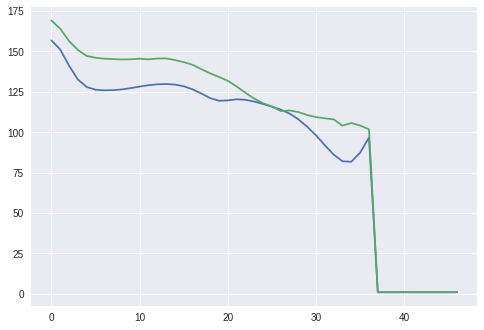

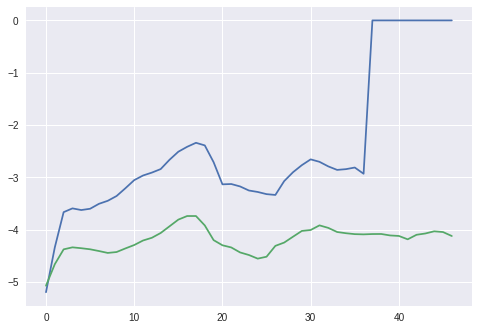

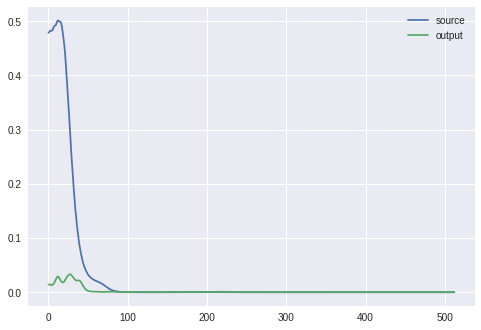

In [59]:
plt.figure()
offset = 0
lim = 100
plt.plot(tofrequency(feature_s[offset:offset+lim,0]))
plt.plot(tofrequency(result_mlpg[offset:offset+lim,0]))
Nc = 1
plt.figure()
plt.plot(feature_s[offset:offset+lim,Nc])
plt.plot(result_mlpg[offset:offset+lim,Nc])
Nwin = 45
# plt.figure()
# plt.plot(feature_s[Nwin,1:])
# plt.plot(result_mlpg[Nwin,1:])
# in sp
mfcc_s = pysptk.conversion.mc2sp(feature_s[Nwin, 1:].astype(np.float64),alpha=alpha, fftlen = nFFTHalf)
mfcc_y = pysptk.conversion.mc2sp(result_mlpg[Nwin, 1:].astype(np.float64),alpha=alpha, fftlen = nFFTHalf)
plt.figure()
print(mfcc_y.shape)
plt.plot(sp_s[Nwin, :])
plt.plot(mfcc_y)
plt.legend(['source', 'output'])


## regenerate

In [60]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(window_len/2-1):-int(window_len/2)-1]

configure_plotly_browser_state()
init_notebook_mode(connected=False)

feature_y = result_mlpg
print(feature_y.shape,fft_size, mcsize+1)

lf0_y = np.array(feature_y[:,0], order='C')
lf0_y[in_uv[:,0]==1] = -1e10


mgc_y = np.array(feature_y[:,1:], order='C')

f0_y = tofrequency(lf0_y)

ap_y = ap_s
sp_y = pysptk.conversion.mc2sp(mgc_y.astype(np.float64),alpha=alpha, fftlen = nFFTHalf)

#f0_y = smooth(f0_y,window_len=11,window='hanning')

f0_s = tofrequency(lf0_s)
ap_s = ap_s
sp_s = pysptk.conversion.mc2sp(mgc_s.astype(np.float64),alpha=alpha, fftlen = nFFTHalf)

# print(sp_coefs2)
print(f0_y.shape)
print(sp_y.shape)
print(ap_y.shape)

x_rec = pw.synthesize(f0_s, sp_s, ap_s, fs_ds, frame_period)


y = pw.synthesize(f0_y, sp_y, ap_y, fs_ds, frame_period)



sf.write(basePath + "/sounds/test_x_fil.wav", x_rec, fs_ds)
wav_player(basePath + "/sounds/test_x_fil.wav")
sf.write(basePath + "/sounds/test_y.wav", y, fs_ds)
wav_player(basePath + "/sounds/test_y.wav")


layout = dict(title = 'SOURCE',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace = go.Scatter(
    x = np.array(range(len(x_rec)))/fs_ds,
    y = x_rec,
    mode = 'lines',
    name = 'x_rec'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)


layout = dict(title = 'RECO',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace = go.Scatter(
    x = np.array(range(len(y)))/fs_ds,
    y = y,
    mode = 'lines',
    name = 'y'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)


layout = dict(title = 'F0',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )

trace1 = go.Scatter(
    x = np.array(range(len(f0_y))),
    y = f0_y,
    mode = 'lines',
    name = 'y'
)
trace2 = go.Scatter(
    x = np.array(range(len(f0_s))),
    y = f0_s,
    mode = 'lines',
    name = 'source'
)
trace3 = go.Scatter(
    x = np.array(range(len(f0_t))),
    y = f0_t,
    mode = 'lines',
    name = 'target'
)


fig = dict(data=[trace1, trace2, trace3], layout=layout)
iplot(fig)


layout = dict(title = 'SP MEAN',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )
#
n = 42;
#
f_range = np.linspace(0,int(fs_ds/2),len(sp_s[0,:]))

trace1 = go.Scatter(
    x = f_range,
    y = np.mean(sp_y,axis=0),
    mode = 'lines',
    name = 'y'
)
trace2 = go.Scatter(
    x = f_range,
    y = np.mean(sp_s,axis=0),
    mode = 'lines',
    name = 'source'
)
trace3 = go.Scatter(
    x = f_range,
    y = np.mean(sp_t,axis=0),
    mode = 'lines',
    name = 'target'
)
fig = dict(data=[trace1, trace2, trace3], layout=layout)
iplot(fig)


layout = dict(title = 'SP ('+str(n)+')',
              xaxis = dict(title = 'y'),
              yaxis = dict(title = 'a'),
              )


trace1 = go.Scatter(
    x = f_range,
    y = sp_y[n,:],
    mode = 'lines',
    name = 'y_net'
)
trace2 = go.Scatter(
    x = f_range,
    y = sp_s[n,:],
    mode = 'lines',
    name = 'source'
)
trace3 = go.Scatter(
    x = f_range,
    y = sp_t[n,:],
    mode = 'lines',
    name = 'target'
)
fig = dict(data=[trace1, trace2, trace3], layout=layout)
iplot(fig)

print(feature_s.shape)

(47, 61) 1024 60
(47,)
(47, 513)
(47, 513)


(47, 61)
